In [1]:
!git clone https://github.com/grayfactory/Toxicity-Under-Context-Detect.git
%cd Toxicity-Under-Context-Detect/
!ls

fatal: destination path 'Toxicity-Under-Context-Detect' already exists and is not an empty directory.
/content/Toxicity-Under-Context-Detect
 BentoML.ipynb
 data
 Electra_with_pair_Sentence_Training_Eval.ipynb
'GTP-neo-fine-tuning(parents-text).ipynb'
'GTP-neo-fine-tuning(toxic-text).ipynb'
 Inference_Time.ipynb
 Preprocessing_data_and_prepare4training.ipynb
 README.md
 utils


In [2]:
!pip install transformers
!pip install datasets

from IPython.display import clear_output 

from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          AdamW, get_linear_schedule_with_warmup,
                          DistilBertTokenizer, DistilBertForSequenceClassification)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

from sklearn.model_selection import StratifiedShuffleSplit

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
from pathlib import Path
import random

from utils._utils import MyConfig, plot_confusion_matrix, plot_history
from utils.model import (tokenize_segmented_text, TOXICDataset, 
                         f1_score_model, AverageMeter, 
                         train_epoch, eval_model, model_score, EarlyStopping)


clear_output()

In [3]:
# for model save
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
!ln -s /content/gdrive/My\ Drive/toxic_nlp /toxic_nlp
!ls /toxic_nlp

ln: failed to create symbolic link '/toxic_nlp/toxic_nlp': File exists
 BentoML.ipynb
 BERT_dynamic_quantiztion_tutorial.ipynb
'Copy of Electra_with_pair_Sentence_Training_Eval.ipynb'
 dataset
 DistilBERT_with_pair_Sentence_Training_Eval.ipynb
 Electra-model
 Electra-model-save
 Electra_with_pair_sentence.ipynb
 Electra_with_pair_sentence_trained_generated_dataset.ipynb
 Electra_with_pair_sentence_trained_vanilla_dataset.ipynb
 Electra_with_pair_Sentence_Training_Eval.ipynb
 fine-tuneWith_transformer_API_tutorial.ipynb
 gpt-neo-checkpoints
'GTP-neo-fine-tuning(parents-text).ipynb'
'GTP-neo-fine-tuning(toxic-text).ipynb'
 Hope-speech-tutorial.ipynb
 Inference_Time.ipynb
 ktrain.ipynb
 Preprocessing_data_and_prepare4training.ipynb
 preprocessing_datasets.ipynb
 pytorch_tutorial.ipynb
 toxic_nlp
 toxic_v1.ipynb
 toxic_v2.ipynb


# Set configs

In [4]:
configs = MyConfig({
    'path_drive' : Path('/toxic_nlp'),
    'path_colab_data' : Path('./data'),
    'seeds' : 42,
    'model_to_use' : 'distilbert-base-uncased',
    'tokenizer_to_use' : 'distilbert-base-uncased',
    'model_ckp_dir' : Path('/toxic_nlp/Electra-model-save')
})
configs.list_csv = [f for f in Path(configs.path_drive /'dataset').glob('*.csv')]

if configs.seeds:
  random.seed(configs.seeds)
  np.random.seed(configs.seeds)
  torch.manual_seed(configs.seeds)


# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
if torch.cuda.is_available():
  configs.device = "cuda"
else: configs.device="cpu"

print("Using {} device".format(configs.device))

configs

Using cuda device


{'device': 'cuda',
 'list_csv': [PosixPath('/toxic_nlp/dataset/gc_clean.csv'),
  PosixPath('/toxic_nlp/dataset/gc_clean_ner.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit_ner.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/generated_dataset.csv'),
  PosixPath('/toxic_nlp/dataset/tweet.csv'),
  PosixPath('/toxic_nlp/dataset/hate_speech18.csv'),
  PosixPath('/toxic_nlp/dataset/jig_train.csv'),
  PosixPath('/toxic_nlp/dataset/merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_train.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_test.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_gan_merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v2_gan_merged.csv')],
 'model_ckp_dir': PosixPath('/toxic_nlp/Electra-model-save'),
 'model_to_us

In [5]:
def get_data_csv_path(configs, condition):
  condition = condition
  return [f for f in configs.list_csv if f'{condition}' in str(f)][0]

In [6]:
df_train = pd.read_csv( get_data_csv_path(configs,'exp_v1_train.csv'), index_col=0)
df_test = pd.read_csv( get_data_csv_path(configs, 'exp_v1_test.csv'), index_col=0)



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_train.label.value_counts() / df_train.shape[0]

0    0.845665
1    0.154335
Name: label, dtype: float64

In [8]:
df_train = df_train.reset_index()

In [9]:
from sklearn.model_selection import train_test_split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=configs.seeds)

for train_idx, val_idx in split.split(df_train, df_train['label'] ):
    train, val = df_train.loc[train_idx], df_train.loc[val_idx]

# X, y 만 keep
X_train, y_train = train[['text','parent']], train['label']
X_val, y_val = val[['text','parent']], val['label']

# 도메인간 정확률 비교를 위해 y_src 정보를 keep
X_test, y_test, y_src = df_test[['text','parent']], df_test['label'], df_test[['index','src','label']]

print('\nratio of toxic / non toxic \n',y_train.value_counts() / len(y_train),'\n',
      y_val.value_counts() / len(y_val),
      '\n',y_test.value_counts() / len(y_test))
y_test.value_counts() / len(y_test)


ratio of toxic / non toxic 
 0    0.845667
1    0.154333
Name: label, dtype: float64 
 0    0.845658
1    0.154342
Name: label, dtype: float64 
 0    0.845681
1    0.154319
Name: label, dtype: float64


0    0.845681
1    0.154319
Name: label, dtype: float64

In [10]:
model_esc = DistilBertForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
tokenizer = DistilBertTokenizer.from_pretrained(configs.tokenizer_to_use)

# model_esc = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator').to(configs.device)
# tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [11]:
X_train.shape

(157128, 2)

In [30]:
# configs.max_len = 256
configs.max_len = 128
configs.batch_size = 64
configs.EPOCHS = 10

configs.optimizer = AdamW(model_esc.parameters(), lr=1e-5)
configs.loss_fn = nn.CrossEntropyLoss().to(configs.device)

# model save path set
configs.model_save_dir = configs.path_drive / f'Electra-model-save/distilBERT-ori-model_v1.pt'

configs.early_stop_patience = 4
configs.early_stop_delta = 0.005
# init early stopping
early_stopping = EarlyStopping(patience = configs.early_stop_patience, 
                               delta=configs.early_stop_delta,
                               verbose = True, 
                               path=configs.model_save_dir)

# load dataset
train_dataset = TOXICDataset(X_train, y_train, tokenizer, configs.max_len)
train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=True)

val_dataset = TOXICDataset(X_val, y_val, tokenizer, configs.max_len)
val_loader = DataLoader(val_dataset, batch_size=configs.batch_size, shuffle=True)

configs.total_steps = len(train_loader) * configs.EPOCHS
configs.scheduler = get_linear_schedule_with_warmup(
                    configs.optimizer,
                    num_warmup_steps=0,
                    num_training_steps=configs.total_steps
                )


configs

{'EPOCHS': 10,
 'batch_size': 64,
 'device': 'cuda',
 'early_stop_delta': 0.005,
 'early_stop_patience': 4,
 'list_csv': [PosixPath('/toxic_nlp/dataset/gc_clean.csv'),
  PosixPath('/toxic_nlp/dataset/gc_clean_ner.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit_ner.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/generated_dataset.csv'),
  PosixPath('/toxic_nlp/dataset/tweet.csv'),
  PosixPath('/toxic_nlp/dataset/hate_speech18.csv'),
  PosixPath('/toxic_nlp/dataset/jig_train.csv'),
  PosixPath('/toxic_nlp/dataset/merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_train.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_test.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_gan_merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v2_gan_m

## Training Model

In [13]:
def train_epoch_distil(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  f1_score_meter = AverageMeter()

  # iteration by batch size
  for data in tqdm(data_loader):
    # input data
    input_ids = data['input_ids'].to(device)
    attention_masks = data['attention_mask'].to(device)
    token_type_ids = data['token_type_ids'].to(device)
    # true label
    labels = data['label'].to(device)

    y_pred = model(input_ids = input_ids, 
                  attention_mask=attention_masks,
                  # token_type_ids=token_type_ids
                   )[0]

    # print(y_pred, labels)
    loss = loss_fn(y_pred, labels)


    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    _, pred = torch.max(y_pred, dim=1) # indices [0,1] 만 받음, 앞은 max tensor값
    correct_predictions += torch.sum(pred == labels)
    losses.append(loss.item())

    f1_value = f1_score_model(labels, pred)
    f1_score_meter.update(f1_value, len(labels))

  # mean loss, number of correct_prediction (each batch)
  return correct_predictions.double() / n_examples, np.mean(losses), f1_score_meter


def eval_model_distil(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  f1_score_meter = AverageMeter()

  with torch.no_grad():
    for data in tqdm(data_loader):

      input_ids = data['input_ids'].to(device)
      attention_masks = data['attention_mask'].to(device)
      token_type_ids = data['token_type_ids'].to(device)
      labels = data['label'].to(device)

      y_pred = model(input_ids = input_ids, 
                    attention_mask=attention_masks,
                    # token_type_ids=token_type_ids
                     )[0]

      _, pred = torch.max(y_pred, dim=1)
      loss = loss_fn(y_pred, labels)
      correct_predictions += torch.sum(pred == labels)
      losses.append(loss.item())

      f1_value = f1_score_model(labels, pred)
      f1_score_meter.update(f1_value, len(labels))

  return correct_predictions.double() / n_examples, np.mean(losses), f1_score_meter

  0%|          | 0/2456 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.114335).  Saving model ...
Train Loss 0.09571 accuracy 0.96377 f1 0.87282
Val Loss 0.11433 accuracy 0.95604 f1 0.85303



  0%|          | 0/2456 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
Train Loss 0.07332 accuracy 0.97262 f1 0.90529
Val Loss 0.11823 accuracy 0.95764 f1 0.85462



  0%|          | 0/2456 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 4
Train Loss 0.05218 accuracy 0.98121 f1 0.93494
Val Loss 0.13388 accuracy 0.95548 f1 0.84869



  0%|          | 0/2456 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 4
Train Loss 0.03486 accuracy 0.98764 f1 0.95750
Val Loss 0.16340 accuracy 0.95494 f1 0.84957



  0%|          | 0/2456 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 4
Early stopping


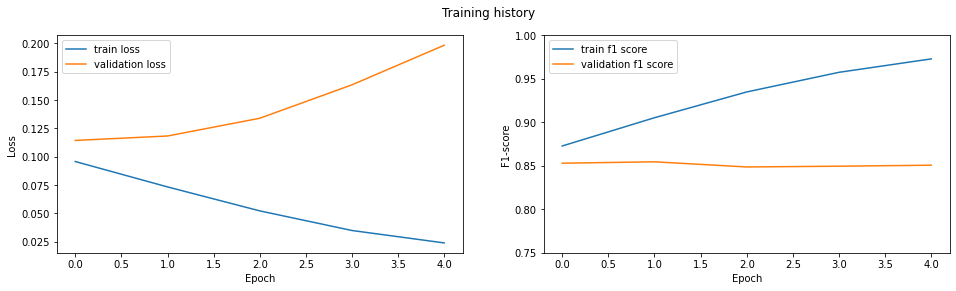

In [31]:
from collections import defaultdict

history = defaultdict(list)

# lets training
for epoch in range(configs.EPOCHS):

  train_acc, train_loss, f1_train = train_epoch_distil(
      model_esc,
      train_loader,
      configs.loss_fn,
      configs.optimizer,
      configs.device,
      configs.scheduler,
      len(train_dataset)
  )

  val_acc, val_loss, f1_val = eval_model_distil(
      model_esc,
      val_loader,
      configs.loss_fn,
      configs.device,
      len(val_dataset)
  )

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_f1'].append(f1_train.avg.item())
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_f1'].append(f1_val.avg.item())

  early_stopping(val_loss, model_esc)

  if early_stopping.early_stop:
    print('Early stopping')
    break

  print(f'Train Loss {train_loss:.5f} accuracy {train_acc:.5f} f1 {f1_train.avg.item():.5f}')
  print(f'Val Loss {val_loss:.5f} accuracy {val_acc:.5f} f1 {f1_val.avg.item():.5f}')
  print()

plot_history(history)

## Evaluation with Test set

In [32]:
def model_score_distil(model, data_loader, configs):
  model = model.eval()

  y_pred_batch = []
  y_true_batch = []
  y_prob_batch = []

  with torch.no_grad():
    for data in tqdm(data_loader):

      input_ids = data['input_ids'].to(configs.device)
      attention_masks = data['attention_mask'].to(configs.device)
      token_type_ids = data['token_type_ids'].to(configs.device)
      labels = data['label'].to(configs.device)

      y_pred = model(input_ids = input_ids, 
                attention_mask=attention_masks,
                # token_type_ids=token_type_ids
                )[0]
      # raw logit to softmax
      prob = F.softmax(y_pred, dim=1)

      _, pred = torch.max(y_pred, dim=1)

      y_pred_batch.append(pred.cpu().tolist())
      y_true_batch.append(labels.cpu().tolist())
      y_prob_batch.append(prob[:,1].cpu().tolist())

  return y_pred_batch, y_true_batch, y_prob_batch

In [33]:
# load test set without shuffle
test_dataset = TOXICDataset(X_test, y_test, tokenizer, configs.max_len)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size)
len(test_dataset)

34662

In [34]:
from sklearn.metrics import f1_score, roc_auc_score
from itertools import chain

y_pred, y_true, y_prob = model_score_distil(model_esc, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)





  0%|          | 0/542 [00:00<?, ?it/s]

In [35]:
print(f'DistilBERT train with  - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')

DistilBERT train with  - Condition
Results f1 : 0.8551, roc auc : 0.9764


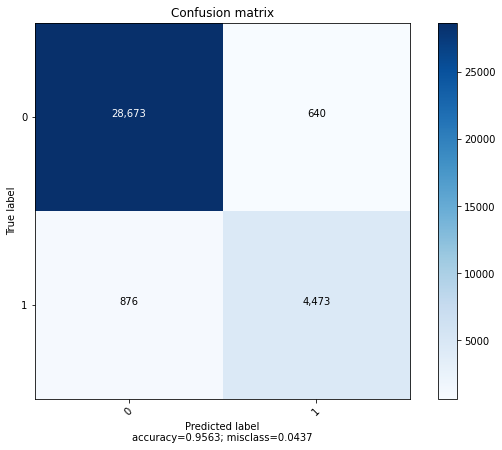

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)

## Electra model evaluation on test-set
### 데이터 도메인(출처)간 평가지표 비교

In [37]:
configs

{'EPOCHS': 10,
 'batch_size': 64,
 'device': 'cuda',
 'early_stop_delta': 0.005,
 'early_stop_patience': 4,
 'list_csv': [PosixPath('/toxic_nlp/dataset/gc_clean.csv'),
  PosixPath('/toxic_nlp/dataset/gc_clean_ner.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit_ner.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/generated_dataset.csv'),
  PosixPath('/toxic_nlp/dataset/tweet.csv'),
  PosixPath('/toxic_nlp/dataset/hate_speech18.csv'),
  PosixPath('/toxic_nlp/dataset/jig_train.csv'),
  PosixPath('/toxic_nlp/dataset/merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_train.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_test.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_gan_merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v2_gan_m

In [38]:
X_test
y_test.value_counts()
y_src.src.value_counts()

1    23865
3     4795
0     4464
2     1538
Name: src, dtype: int64

In [23]:
# incase evaluation with uploaded model
# remodel = gan data를 합쳐서 training 한 버전
configs.model_save_dir = configs.model_ckp_dir / 'distilBERT-ori-model_v1.pt'


In [39]:
# fine-tuning model with condition!
model_generated = DistilBertForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
model_generated.load_state_dict(torch.load(configs.model_save_dir))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

<All keys matched successfully>

In [43]:
# load test set without shuffle
test_dataset = TOXICDataset(X_test, y_test, tokenizer, configs.max_len)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size)
len(test_dataset)

34662

In [44]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from itertools import chain

y_pred, y_true, y_prob = model_score_distil(model_generated, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))


  0%|          | 0/542 [00:00<?, ?it/s]

Electra train with - all source - Condition
Results f1 : 0.8562, roc auc : 0.9824


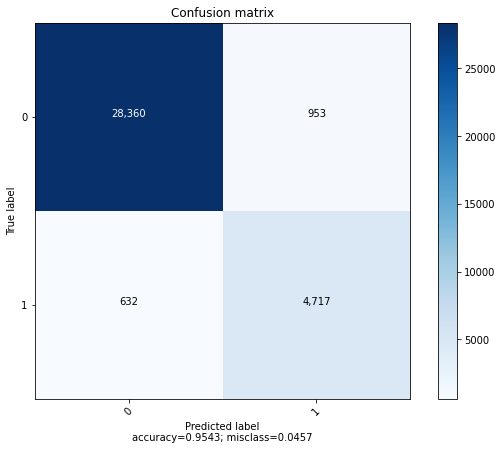

In [45]:
f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)

# print(f'Electra train with - {configs.train_condition} - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')
print(f'Electra train with - all source - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')
cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)

In [46]:
y_src['y_pred_label'] = predicted
y_src['y_pred_prob'] = proba

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Electra predicted subset: gab_reddit-Condition
Results f1 : 0.9591, roc auc : 0.9853


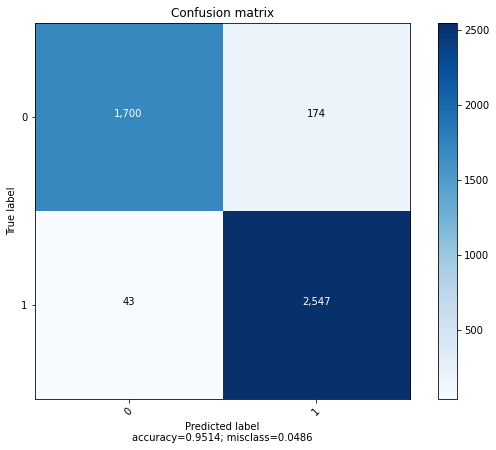

Electra predicted subset: jig-Condition
Results f1 : 0.8051, roc auc : 0.9806


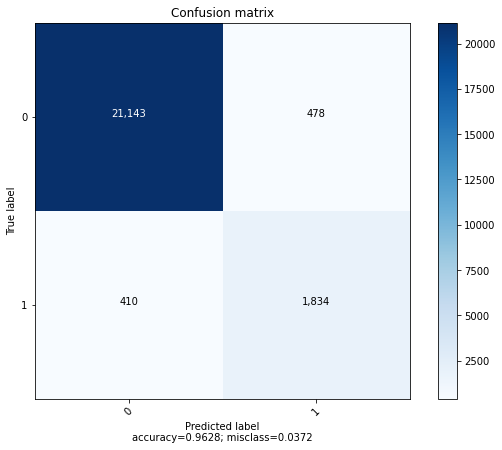

Electra predicted subset: tweet-Condition
Results f1 : 0.5161, roc auc : 0.8774


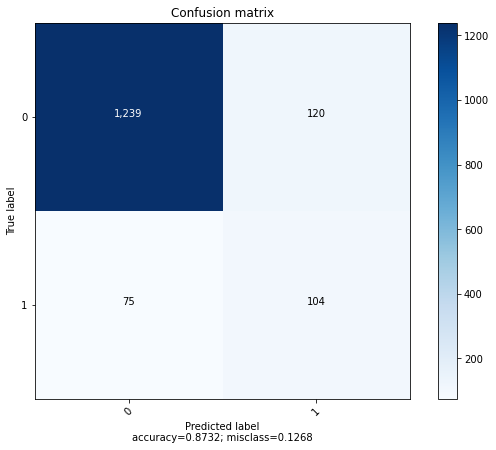

Electra predicted subset: stormfront-Condition
Results f1 : 0.6195, roc auc : 0.9359


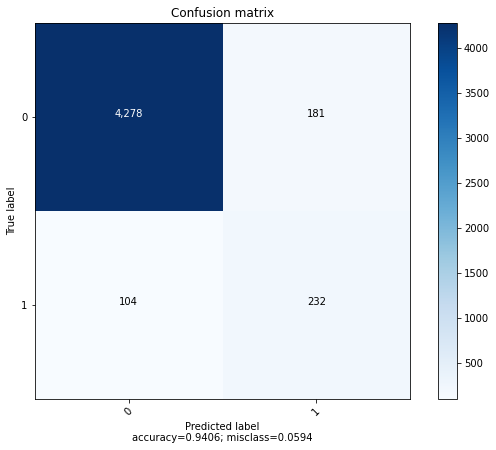

In [47]:
source = ['gab_reddit','jig','tweet','stormfront']

for i, name in enumerate(source):
  sub_true_label = y_src[y_src.src==i]['label']
  sub_predicted = y_src[y_src.src==i]['y_pred_label']
  sub_proba = y_src[y_src.src==i]['y_pred_prob']
  f1, roc_auc = f1_score(sub_true_label, sub_predicted), roc_auc_score(sub_true_label, sub_proba)
  print(f'Electra predicted subset: {name}-Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')
  cm = confusion_matrix(sub_true_label, sub_predicted)
  target_name = [0,1]

  plot_confusion_matrix(cm, target_name, normalize=False)

## gen 문장이 포함되었을 때, 포함되지 않았을 때 모델의 분류가 달라지는 문장을 구체적으로 살펴보기

In [48]:
configs

{'EPOCHS': 10,
 'batch_size': 64,
 'device': 'cuda',
 'early_stop_delta': 0.005,
 'early_stop_patience': 4,
 'list_csv': [PosixPath('/toxic_nlp/dataset/gc_clean.csv'),
  PosixPath('/toxic_nlp/dataset/gc_clean_ner.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit_ner.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/generated_dataset.csv'),
  PosixPath('/toxic_nlp/dataset/tweet.csv'),
  PosixPath('/toxic_nlp/dataset/hate_speech18.csv'),
  PosixPath('/toxic_nlp/dataset/jig_train.csv'),
  PosixPath('/toxic_nlp/dataset/merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_train.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_test.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_gan_merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v2_gan_m

In [49]:
# trained by original data
model_original = DistilBertForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
model_original.load_state_dict(torch.load(configs.model_ckp_dir / 'distilBERT-ori-model_v1.pt'))
# trained by original+generated data
model_generated = DistilBertForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
model_generated.load_state_dict(torch.load(configs.model_ckp_dir / 'distilBERT-remodel_v1.pt'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

<All keys matched successfully>

In [50]:
# load test set without shuffle
test_dataset = TOXICDataset(X_test, y_test, tokenizer, configs.max_len)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size)
len(test_dataset)

34662

In [53]:
y_pred, y_true, y_prob = model_score_distil(model_original, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

y_src['y_pred_label_ori'] = predicted
y_src['y_pred_prob_ori'] = proba



  0%|          | 0/542 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [54]:
y_pred, y_true, y_prob = model_score_distil(model_generated, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

y_src['y_pred_label_gen'] = predicted
y_src['y_pred_prob_gen'] = proba

  0%|          | 0/542 [00:00<?, ?it/s]

In [61]:
# model에 따라서 분류가 달라진 경우(맥락을 포함할때)
test_case = y_src[ (y_src.y_pred_label_ori != y_src.y_pred_label_gen) & (y_src.src==0) ]

In [66]:
test_case

,index,src,label,y_pred_label,y_pred_prob,y_pred_label_ori,y_pred_prob_ori,y_pred_label_gen,y_pred_prob_gen
15,28779,0,0,0,0.365458,0,0.365458,1,0.515971
47,22603,0,1,0,0.467263,0,0.467263,1,0.600962
216,27477,0,0,0,0.292785,0,0.292785,1,0.676121
263,9210,0,0,0,0.126828,0,0.126828,1,0.603626
306,29501,0,0,0,0.496593,0,0.496593,1,0.643787
...,...,...,...,...,...,...,...,...,...
4275,6331,0,1,1,0.681156,1,0.681156,0,0.071862
4346,19325,0,0,1,0.514251,1,0.514251,0,0.317410
4350,28763,0,1,0,0.387422,0,0.387422,1,0.680476
4372,728,0,1,1,0.580542,1,0.580542,0,0.353087


In [65]:
sum(test_case.label == test_case.y_pred_label_ori), sum(test_case.label == test_case.y_pred_label_gen)

(42, 40)